In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/DACNTT/Dataset/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: cats/CAT_05/00001130_020.jpg.cat  
  inflating: cats/CAT_05/00001130_023.jpg  
  inflating: cats/CAT_05/00001130_023.jpg.cat  
  inflating: cats/CAT_05/00001130_026.jpg  
  inflating: cats/CAT_05/00001130_026.jpg.cat  
  inflating: cats/CAT_05/00001131_003.jpg  
  inflating: cats/CAT_05/00001131_003.jpg.cat  
  inflating: cats/CAT_05/00001131_026.jpg  
  inflating: cats/CAT_05/00001131_026.jpg.cat  
  inflating: cats/CAT_05/00001132_007.jpg  
  inflating: cats/CAT_05/00001132_007.jpg.cat  
  inflating: cats/CAT_05/00001132_008.jpg  
  inflating: cats/CAT_05/00001132_008.jpg.cat  
  inflating: cats/CAT_05/00001132_014.jpg  
  inflating: cats/CAT_05/00001132_014.jpg.cat  
  inflating: cats/CAT_05/00001132_017.jpg  
  inflating: cats/CAT_05/00001132_017.jpg.cat  
  inflating: cats/CAT_05/00001132_018.jpg  
  inflating: cats/CAT_05/00001132_018.jpg.cat  
  inflating: cats/CAT_05/00001132_021.jpg  
  inflating: cats/CAT_05/0000

In [3]:
import numpy as np
import cv2
import os
import random
import dlib
import pandas as pd
import datetime
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [4]:
img_size = 224
dataset_path = '/content/cats'

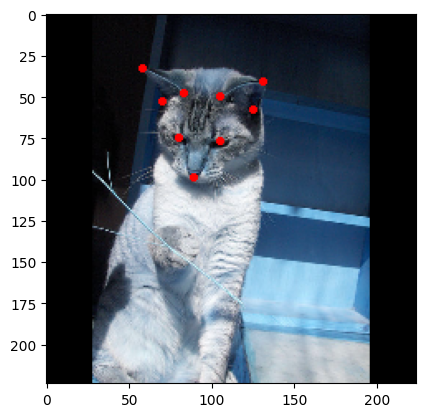

In [5]:
for dirname in ['CAT_00', 'CAT_01', 'CAT_02', 'CAT_03', 'CAT_04', 'CAT_05', 'CAT_06']:
    base_path = os.path.join(dataset_path, dirname)
    file_list = sorted(os.listdir(base_path))
    random.shuffle(file_list)

    dataset = {
        'imgs': [],
        'lmks': [],
        'bbs': []
    }

    def resize_img(im):
      old_size = im.shape[:2] # old_size is in (height, width) format
      ratio = float(img_size) / max(old_size)
      new_size = tuple([int(x*ratio) for x in old_size])
      # new_size should be in (width, height) format
      im = cv2.resize(im, (new_size[1], new_size[0]))
      delta_w = img_size - new_size[1]
      delta_h = img_size - new_size[0]
      top, bottom = delta_h // 2, delta_h - (delta_h // 2)
      left, right = delta_w // 2, delta_w - (delta_w // 2)
      new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
          value=[0, 0, 0])
      return new_im, ratio, top, left

    for f in file_list:
      if '.cat' not in f:
        continue

      # read landmarks
      pd_frame = pd.read_csv(os.path.join(base_path, f), sep=' ', header=None)
      landmarks = (pd_frame.values[0][1:-1]).reshape((-1, 2))

      # load image
      img_filename, ext = os.path.splitext(f)

      img = cv2.imread(os.path.join(base_path, img_filename))

      # resize image and relocate landmarks
      img, ratio, top, left = resize_img(img)
      landmarks = ((landmarks * ratio) + np.array([left, top])).astype(int)
      bb = np.array([np.min(landmarks, axis=0), np.max(landmarks, axis=0)])

      # Visualize new image and landmarks
      for i in landmarks:
        cv2.circle(img, center=tuple(i), radius=1, color=(255, 0, 0), thickness=2)
      plt.imshow(img)

      dataset['imgs'].append(img)
      dataset['lmks'].append(landmarks.flatten())
      dataset['bbs'].append(bb.flatten())

    np.save('bbs_%s.npy' % dirname, np.array(dataset))

In [6]:
mode = 'bbs' # [bbs, lmks]
if mode is 'bbs':
  output_size = 4
elif mode is 'lmks':
  output_size = 18

In [7]:
# Load data
data_00 = np.load('bbs_CAT_00.npy', allow_pickle=True).item()
data_01 = np.load('bbs_CAT_01.npy', allow_pickle=True).item()
data_02 = np.load('bbs_CAT_02.npy', allow_pickle=True).item()
data_03 = np.load('bbs_CAT_03.npy', allow_pickle=True).item()
data_04 = np.load('bbs_CAT_04.npy', allow_pickle=True).item()
data_05 = np.load('bbs_CAT_05.npy', allow_pickle=True).item()
data_06 = np.load('bbs_CAT_06.npy', allow_pickle=True).item()

In [8]:
# Combine data from all directories
all_data = {
    'imgs': np.concatenate([data_00['imgs'], data_01['imgs'], data_02['imgs'], data_03['imgs'], data_04['imgs'], data_05['imgs'], data_06['imgs']]),
    'lmks': np.concatenate([data_00['lmks'], data_01['lmks'], data_02['lmks'], data_03['lmks'], data_04['lmks'], data_05['lmks'], data_06['lmks']]),
    'bbs': np.concatenate([data_00['bbs'], data_01['bbs'], data_02['bbs'], data_03['bbs'], data_04['bbs'], data_05['bbs'], data_06['bbs']])
}

In [9]:
# Normalize the landmarks to be in the range [0, 1]
def normalize_data(data):
    imgs = data['imgs']
    lmks = data['lmks']
    bbs = data['bbs']
    lmks = lmks.astype(np.float32)
    bbs = bbs.astype(np.float32)
    lmks = lmks / 224.0
    bbs = bbs / 224.0
    return imgs, lmks, bbs

# Split data into training and testing sets
def split_data(imgs, lmks, bbs):
    train_imgs, test_imgs, train_lmks, test_lmks, train_bbs, test_bbs = train_test_split(imgs, lmks, bbs, test_size=0.1, random_state=42)
    return train_imgs, test_imgs, train_lmks, test_lmks, train_bbs, test_bbs

# Load data
imgs, lmks, bbs = normalize_data(all_data)
train_imgs, test_imgs, train_lmks, test_lmks, train_bbs, test_bbs = split_data(imgs, lmks, bbs)


In [10]:
# Create the model
def create_model():
    input = Input(shape=(224, 224, 3))
    model = MobileNetV2(input_tensor=input, include_top=False, weights='imagenet')
    x = model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(output_size, activation='linear')(x)
    model = Model(model.input, x)
    return model

# Create the model
model = create_model()

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [12]:
history = model.fit(train_imgs, train_bbs, epochs= 50, batch_size= 16, validation_data=(test_imgs, test_bbs))

Epoch 1/50
563/563 [==============================] - 80s 81ms/step - loss: 0.0078 - val_loss: 1.0123
Epoch 2/50
563/563 [==============================] - 41s 72ms/step - loss: 0.0016 - val_loss: 0.1042
Epoch 3/50
563/563 [==============================] - 41s 73ms/step - loss: 7.3399e-04 - val_loss: 0.0449
Epoch 4/50
563/563 [==============================] - 43s 76ms/step - loss: 4.7576e-04 - val_loss: 0.0124
Epoch 5/50
563/563 [==============================] - 40s 72ms/step - loss: 4.6449e-04 - val_loss: 0.0236
Epoch 6/50
563/563 [==============================] - 41s 72ms/step - loss: 6.6748e-04 - val_loss: 0.0063
Epoch 7/50
563/563 [==============================] - 41s 73ms/step - loss: 4.1080e-04 - val_loss: 0.0049
Epoch 8/50
563/563 [==============================] - 41s 74ms/step - loss: 3.5295e-04 - val_loss: 0.0040
Epoch 9/50
563/563 [==============================] - 41s 72ms/step - loss: 2.4801e-04 - val_loss: 0.0023
Epoch 10/50
563/563 [==============================] -

In [13]:
# Save the model
model.save('bbs.h5')


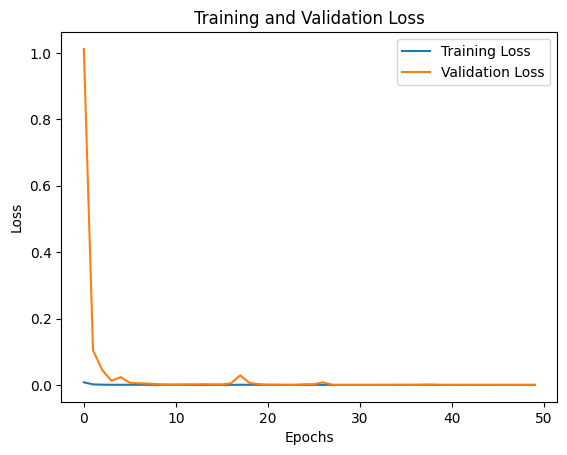

In [14]:
# Plot the training and validation loss
plt.title("Training and Validation Loss")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

32/32 [==============================] - 2s 35ms/step - loss: 7.9682e-05
Validation Loss: 7.968246791278943e-05
32/32 [==============================] - 2s 35ms/step


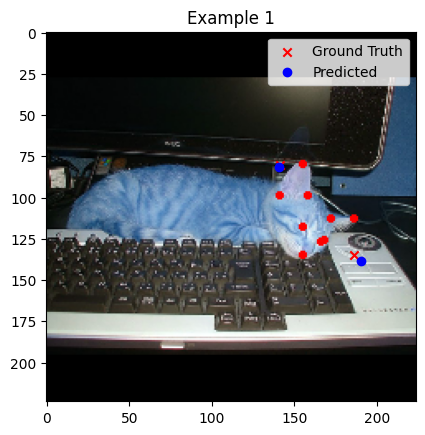

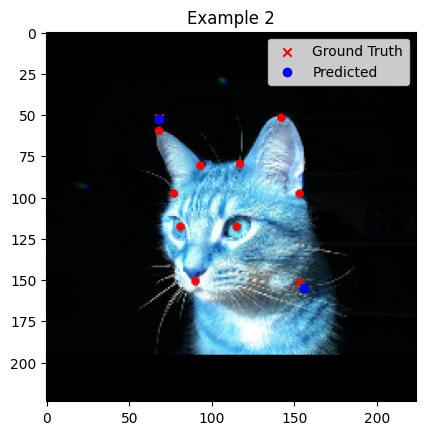

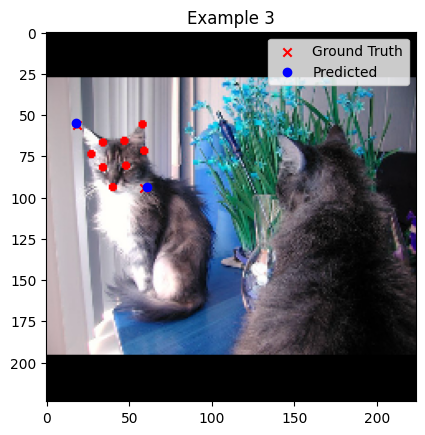

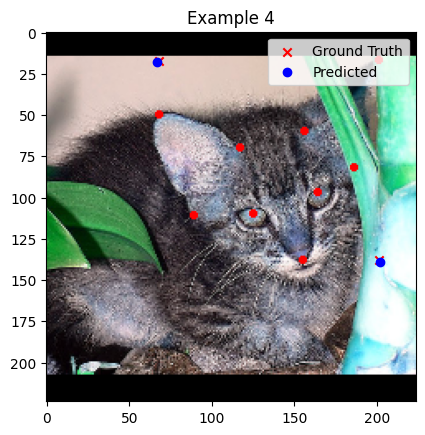

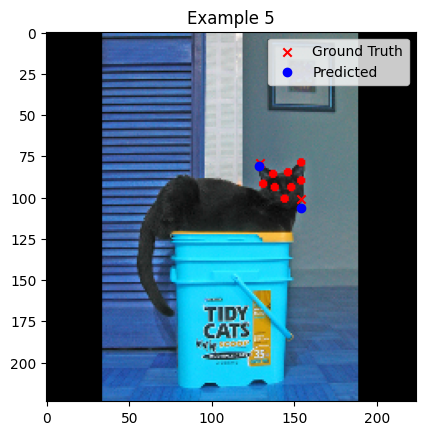

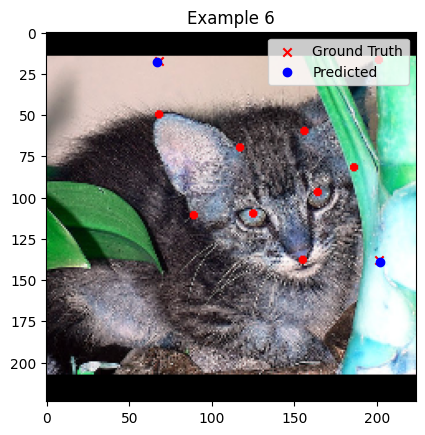

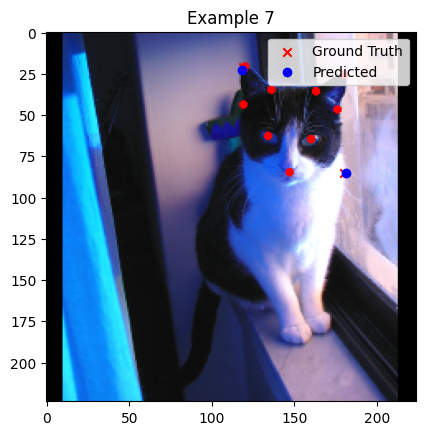

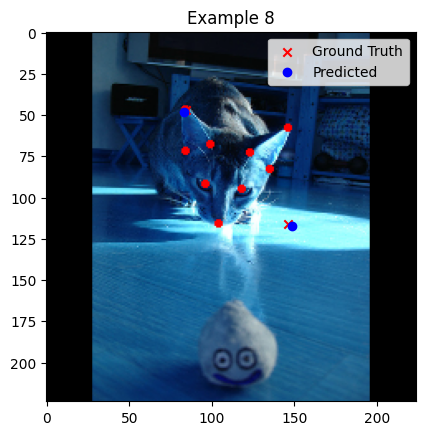

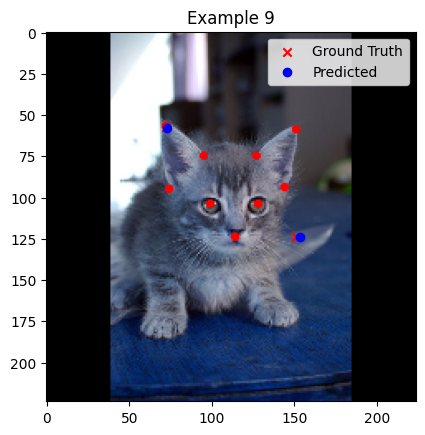

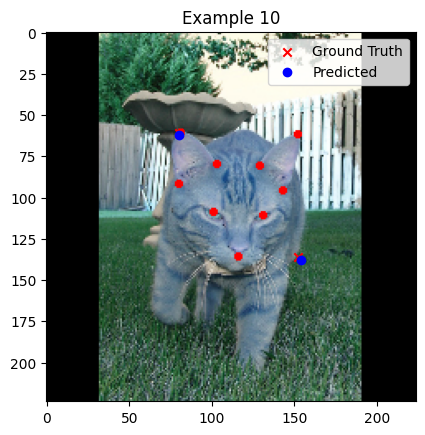

In [15]:
# Evaluate the model on the validation set
val_loss = model.evaluate(test_imgs, test_bbs)
print(f'Validation Loss: {val_loss}')

# Make predictions on the validation set
val_predictions = model.predict(test_imgs)

# Denormalize the landmarks
val_predictions_denorm = val_predictions * 224.0
test_bbs_denorm = test_bbs * 224.0

# Visualize a few examples
num_examples_to_visualize = 10

for i in range(num_examples_to_visualize):
    # Get a random index
    idx = np.random.randint(0, len(test_imgs))

    # Get the image, ground truth landmarks, and predicted landmarks
    img = test_imgs[idx]
    ground_truth_bbs = test_bbs_denorm[idx]
    predicted_bbs = val_predictions_denorm[idx]

    # Visualize the image with ground truth and predicted landmarks
    plt.imshow(img)
    plt.scatter(ground_truth_bbs[0::2], ground_truth_bbs[1::2], c='red', marker='x', label='Ground Truth')
    plt.scatter(predicted_bbs[0::2], predicted_bbs[1::2], c='blue', marker='o', label='Predicted')
    plt.title(f'Example {i + 1}')
    plt.legend()
    plt.show()
